# Proxy

In [ ]:
# # pip install nb_mypy
# %load_ext nb_mypy
# %nb_mypy On

In [ ]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

from typing import Any, Tuple, List, Dict, Set

Allostery:
<div>
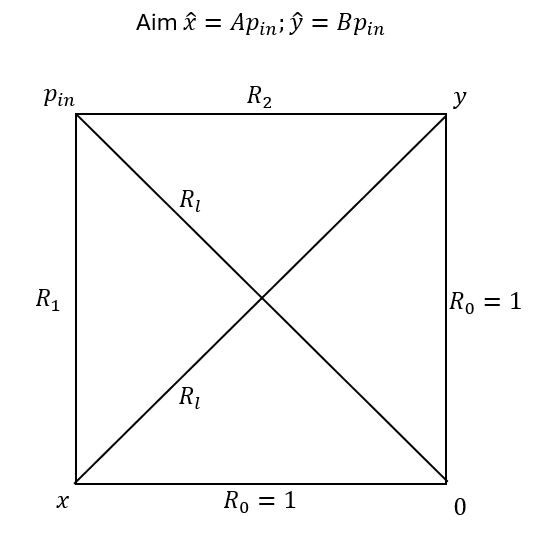
</div>


In [ ]:
## Ugly Classes

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 
        elif variabs.task_type == 'General_reg_allRsChange':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, self.R4, self.R5, self.R6, self.R7, self.R8, self.R9, \
            self.R10, self.R11, self.R12, self.R13, self.R14, self.R15, self.p1, self.p2 = sp.symbols('x y z R1 R2 R3 R4 R5 R6 R7 R8 R9 R10 R11 R12 R13 R14 R15 p1 p2')


In [ ]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma, use_p_tag=True, R_update: str = 'propto'):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma
        self.use_p_tag = use_p_tag 
        self.R_update = R_update  # 'propto' if R=gamma*delta_p
                                  # 'deltaR' if deltaR=gamma*delta_p, gamma should be small


class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        # inital resistance, out_dual and p_in
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([7.,7.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
        elif self.variabs.task_type == 'General_reg':
            self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            # self.R_in_t = [np.array([18.7,2.4,4.0,-13.5,-12.8,1.5])]  # theoretical one
            # self.R_in_t = [np.array([13.8,7.3,-1.5,-8.0,-2.4,-8.9])]  # solved using pinv as in matlab code
                                                                        # "Calculate_desired_resistances_GeneralReg2024.m"
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
        elif self.variabs.task_type == 'General_reg_allRsChange':
            self.R_in_t = [np.ones((15), dtype=float)]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            
        # initalized drawn sample vec and loss func
        if self.variabs.task_type == 'Allostery':
            self.loss_fn = loss_fn_allostery
        else:
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + \
                     (syms.x-syms.y)**2 + (syms.y-syms.z)**2 + (syms.x-syms.z)**2
        elif self.variabs.task_type == 'General_reg_allRsChange':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2/syms.R7 + syms.p2**2/syms.R8 + syms.x**2/syms.R9 + syms.y**2/syms.R10 + \
                     syms.z**2/syms.R11 + (syms.p1-syms.p2)**2/syms.R12 + (syms.x-syms.y)**2/syms.R13 + \
                     (syms.y-syms.z)**2/syms.R14 + (syms.x-syms.z)**2/syms.R15
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg' or self.variabs.task_type == 'General_reg_allRsChange':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
        if self.variabs.task_type == 'Allostery':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        elif self.variabs.task_type == 'General_reg_allRsChange':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
            
        # display and save output in time
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if type(output_prev)==int and type(desired)!=np.float64:  # if desired not scalar, must change other sizes as well
            output_prev = np.zeros(len(desired))
            desired_prev = np.zeros(len(desired))
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg' \
             or self.variabs.task_type=='General_reg_allRsChange':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg' \
             or self.variabs.task_type=='General_reg_allRsChange':
            p_drawn = self.p_drawn_in_t[-1]
            if self.variabs.use_p_tag:
                p_drawn_prev = self.p_drawn_in_t[-2]
                p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
            else:
                p_nxt = p - (p_drawn)*np.dot(self.variabs.alpha, loss[0])          
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]))            
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        
        # pressure changes without memory?
        if self.variabs.R_update == 'deltaR' and np.shape(self.p_in_t)[0]>1:  # make sure its not initial value
            p_nxt -= p  # erase memory
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg' \
        or self.variabs.task_type=='General_reg_allRsChange':
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        
        # BCs change without memory?
        if self.variabs.R_update == 'deltaR' and np.shape(self.out_dual_in_t)[0]>1:  # make sure its not initial value
            self.output -= out_dual  # erase memory
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        elif self.variabs.task_type=='General_reg':
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            self.R_in_t.append(R_ij)
            # self.R_in_t.append(self.R_in_t[0])
        elif self.variabs.task_type=='General_reg_allRsChange':
            R_ij = []
            # inputs to outputs
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            # input to ground
            for i, p in enumerate(self.p_in_t[-1]):
                R_ij.append(self.variabs.gamma[i] * (p - 0))
            # outputs to ground
            for j, out, in enumerate(self.output):
                R_ij.append(self.variabs.gamma[j] * (out - 0))
            # inputs between themselves
            R_ij.append(self.variabs.gamma[0] * (self.p_in_t[-1][0] - self.p_in_t[-1][1]))
            # outputs between themselves
            for i, out in enumerate(self.output):
                R_ij.append(self.variabs.gamma[0] * (self.output[i] - self.output[(i+1)%3]))
            self.R_in_t.append(R_ij)
        
        # if deltaR=gamma*delta_p
        if self.variabs.R_update == 'deltaR' and np.shape(self.R_in_t)[0]>1:  # make sure its not initial value
            print('update is deltaR')
            self.R_in_t[-1] += self.R_in_t[-2]  # update previous value [-2], gamma should be small
            
        # optionally display resistances
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [ ]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0, use_p_tag=True, R_update: str ='propto'):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        gamma = -np.array([0.5, 0.5])  # how much resistance changed due to pressure difference
        # gamma = -np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg' or task_type=='General_reg_allRsChange':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.05
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.02
        F = 0.3
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma, use_p_tag=use_p_tag, R_update=R_update)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg' or task_type=='General_reg_allRsChange':
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    if use_p_tag:
                        state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    else:
                        state.calc_loss(desired)
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$p\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$', r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        # legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$', \
                   r'$\frac{z}{z\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$z\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$',
                   r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_3$', r'$R_4$', r'$R_5$', r'$R_6$']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3.2))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:]/desired-1)
        ax1.plot(np.zeros(len(state.out_in_t[1:])), '--')
    # regression goes only every two samples
    elif variabs.task_type=='Regression' or variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, \
                 np.asarray(state.out_in_t[1:])/np.asarray(state.desired_in_t[1:])-1)
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.set_ylim([-0.2,0.2])
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    if variabs.task_type=='Allostery' or variabs.task_type=='Regression':  # loss is 2D in Allostery
        ax4.plot(np.abs(state.loss_in_t[1:]))
    elif variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':    
        ax4.plot(np.mean(np.mean(np.abs(state.loss_in_t[1:]), axis=1),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [ ]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([-1.0])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
task_type: str =  'Allostery'
# task_type: str = 'Regression'
# task_type: str = 'General_reg'
# task_type: str = 'General_reg_allRsChange'

# R_update = 'propto'
R_update = 'deltaR'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training: int = len(alpha_vec[0])
else:
    training = 320

In [ ]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0, \
                                                   use_p_tag=True, R_update=R_update)

In [ ]:
legends = [['x', 'x desired'], ['y', 'y desired'], ['z', 'z desired']]
if variabs.task_type=='Allostery':
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    for i in range(2):
        axes[i].plot(np.linspace(0, state.t, state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(desired[i]*np.ones(state.t).T, '--')
        axes[i].legend(legends[i])        
    for i in range(2):
        fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
        plt.plot(np.linspace(0, state.t, state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        plt.plot(desired[i]*np.ones(state.t).T, '--')
        plt.legend(legends[i])
elif variabs.task_type=='Regression':
    fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
    axes.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:])
    axes.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t), '--')
    axes.legend(legends[0])           
# regression goes only every two samples
elif task_type=='General_reg' or task_type=='General_reg_allRsChange':
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
    for i in range(3):
        axes[i].plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        axes[i].legend(legends[i])        
    for i in range(3):
        fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
        plt.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        plt.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        plt.legend(legends[i])

In [ ]:
import pandas as pd

loss_1d_in_t = np.mean(np.mean(np.abs(state.loss_in_t), axis=1), axis=1)

# Convert the numpy array to a pandas Series
loss_series = pd.Series(loss_1d_in_t)

# Calculate the moving mean with a window size of 3
moving_mean = loss_series.rolling(window=12).mean()

# Convert back to numpy array if needed
moving_mean_array = moving_mean.to_numpy()

print(moving_mean_array)

# plt.plot(loss_1d_in_t)
plt.plot(moving_mean_array)
plt.xlabel('$t$')
plt.ylabel('$Loss$')

In [ ]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")

In [ ]:
def f(n: int) -> str:
    """Convert number to string.
    """
    return n